# Interpolate data points to fill up NaN values

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import Callback

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
humidity = pd.read_csv("humidity.csv")
temp = pd.read_csv("temperature.csv")
pressure = pd.read_csv("pressure.csv")

In [3]:
humidity_SF = humidity[['datetime','San Francisco']]
temp_SF = temp[['datetime','San Francisco']]
pressure_SF = pressure[['datetime','San Francisco']]

In [4]:
humidity_SF.head(10)

,datetime,San Francisco
0,2012-10-01 12:00:00,NaN
1,2012-10-01 13:00:00,88.0
2,2012-10-01 14:00:00,87.0
3,2012-10-01 15:00:00,86.0
4,2012-10-01 16:00:00,85.0
5,2012-10-01 17:00:00,84.0
6,2012-10-01 18:00:00,83.0
7,2012-10-01 19:00:00,82.0
8,2012-10-01 20:00:00,81.0
9,2012-10-01 21:00:00,80.0


In [5]:
humidity_SF.tail(10)

,datetime,San Francisco
45243,2017-11-29 15:00:00,NaN
45244,2017-11-29 16:00:00,NaN
45245,2017-11-29 17:00:00,NaN
45246,2017-11-29 18:00:00,NaN
45247,2017-11-29 19:00:00,NaN
45248,2017-11-29 20:00:00,NaN
45249,2017-11-29 21:00:00,NaN
45250,2017-11-29 22:00:00,NaN
45251,2017-11-29 23:00:00,NaN
45252,2017-11-30 00:00:00,NaN


In [6]:
print(humidity_SF.shape)
print(temp_SF.shape)
print(pressure_SF.shape)

(45253, 2)
(45253, 2)
(45253, 2)


# CHECK FOR BLANK ENTRIES

Preprocessing

In [7]:
print("How many NaN are there in the humidity dataset?",humidity_SF.isna().sum()['San Francisco'])
print("How many NaN are there in the temperature dataset?",temp_SF.isna().sum()['San Francisco'])
print("How many NaN are there in the pressure dataset?",pressure_SF.isna().sum()['San Francisco'])

How many NaN are there in the humidity dataset? 942
How many NaN are there in the temperature dataset? 793
How many NaN are there in the pressure dataset? 815


### Choosing a point in the time-series for training data

We choose Tp=7000 here which means we will train the RNN with only first 7000 data points and then let it predict the long-term trend (for the next > 35000 data points or so). That is not a lot of training data compared to the number of test points, is it?

In [8]:
Tp = 7000

In [9]:
def plot_train_points(quantity='humidity',Tp=7000):
    plt.figure(figsize=(15,4))
    if quantity=='humidity':
        plt.title("Humidity of first {} data points".format(Tp),fontsize=16)
        plt.plot(humidity_SF['San Francisco'][:Tp],c='k',lw=1)
    if quantity=='temperature':
        plt.title("Temperature of first {} data points".format(Tp),fontsize=16)
        plt.plot(temp_SF['San Francisco'][:Tp],c='k',lw=1)
    if quantity=='pressure':
        plt.title("Pressure of first {} data points".format(Tp),fontsize=16)
        plt.plot(pressure_SF['San Francisco'][:Tp],c='k',lw=1)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

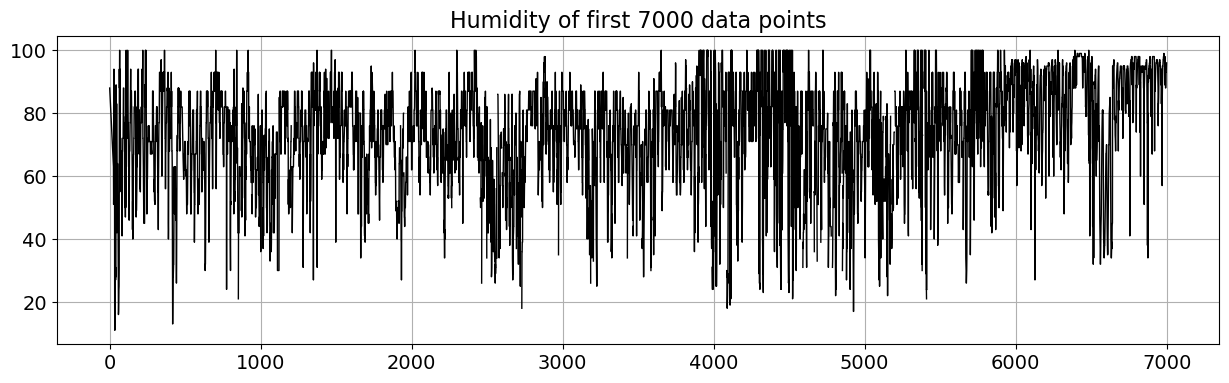

In [10]:
plot_train_points('humidity')

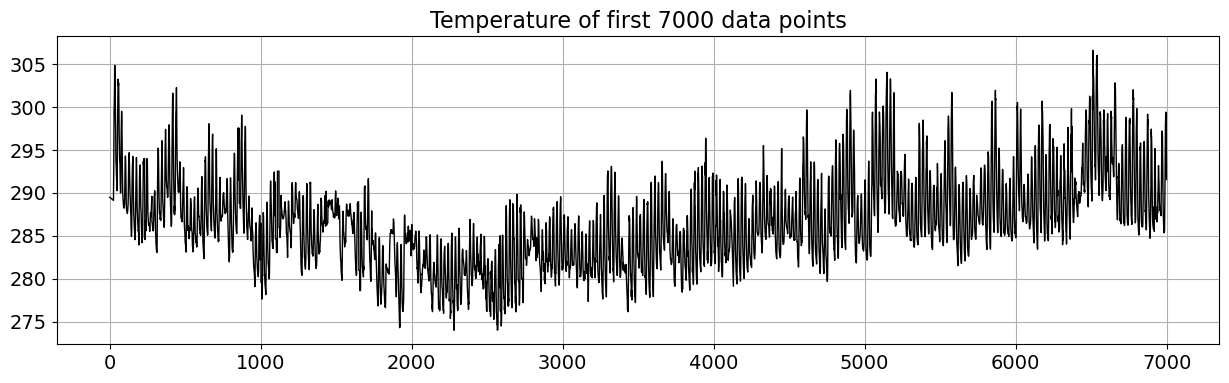

In [11]:
plot_train_points('temperature')

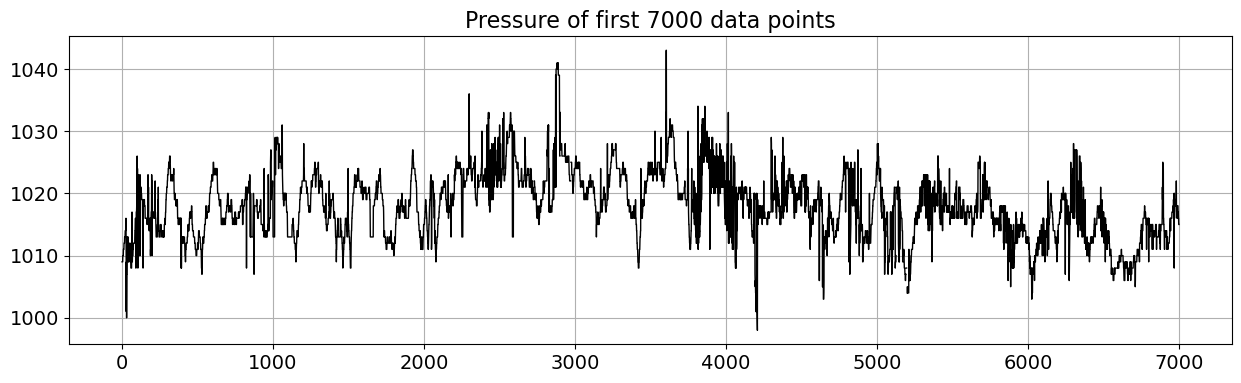

In [12]:
plot_train_points('pressure')

interpolation is a type of estimation, a method of constructing (finding) new data points based on the range of a discrete set of known data points. This is because We observed some NaN values in the dataset. We could just eliminate these points. But assuming that the changes in the parameters are not extremely abrupt, we could try to fill them using simple linear interpolation.

In [13]:
humidity_SF.interpolate(inplace=True)
humidity_SF.dropna(inplace=True)

temp_SF.interpolate(inplace=True)
temp_SF.dropna(inplace=True)

pressure_SF.interpolate(inplace=True)
pressure_SF.dropna(inplace=True)

In [14]:
print(humidity_SF.shape)
print(temp_SF.shape)
print(pressure_SF.shape)

(45252, 2)
(45252, 2)
(45252, 2)


# Train and test splits on the Tp=7000

In [15]:
train = np.array(humidity_SF['San Francisco'][:Tp])
test = np.array(humidity_SF['San Francisco'][Tp:])

/tmp/ipykernel_29739/3462807657.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train = np.array(humidity_SF['San Francisco'][:Tp])
/tmp/ipykernel_29739/3462807657.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  test = np.array(humidity_SF['San Francisco'][Tp:])


In [16]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (7000,)
Test data length: (38252,)


In [17]:
train=train.reshape(-1,1)
test=test.reshape(-1,1)

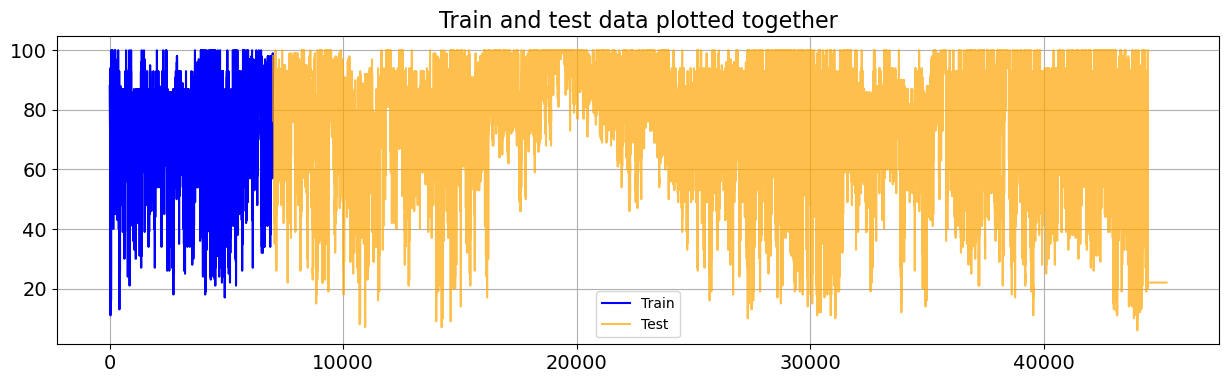

In [18]:
plt.figure(figsize=(15,4))
plt.title("Train and test data plotted together",fontsize=16)
plt.plot(np.arange(Tp),train,c='blue')
plt.plot(np.arange(Tp,45252),test,c='orange',alpha=0.7)
plt.legend(['Train','Test'])
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [19]:
step = 8

In [20]:
# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

In [21]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (7008,)
Test data length: (38260,)


Converting to a multi-dimensional array
Next, we'll convert test and train data into the matrix with step value as it has shown above example.

In [22]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [23]:
trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

In [24]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [25]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (7000, 1, 8) ,  (7000,)
Test data shape: (38252, 1, 8) ,  (38252,)


# Building the Model

In [26]:
def build_simple_rnn(num_units=128, embedding=4,num_dense=32,lr=0.001):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    model.add(SimpleRNN(units=num_units, input_shape=(1,embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])
    
    return model

In [27]:
model_humidity = build_simple_rnn(num_units=128,num_dense=32,embedding=8,lr=0.0005)

NameError: name 'Sequential' is not defined

In [28]:
model_humidity.summary()

NameError: name 'model_humidity' is not defined

# A simple Keras Callback class to print progress of the training at regular epoch interval

Since the RNN training is usually long, we want to see regular updates about epochs finishing. However, we may not want to see this update every epoch as that may flood the output stream. Therefore, we write a simple custom Callback function to print the finishing update every 50th epoch. You can think of adding other bells and whistles to this function to print error and other metrics dynamically.

In [29]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

NameError: name 'Callback' is not defined

# Assign Batch Size and no. of epochs

In [30]:
batch_size=8
num_epochs = 1000

# Train the Model

In [31]:
model_humidity.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

NameError: name 'model_humidity' is not defined

# Plot RMSE loss over epochs
Note that the loss metric available in the history attribute of the model is the MSE loss and you have to take a square-root to compute the RMSE loss.

NameError: name 'model_humidity' is not defined

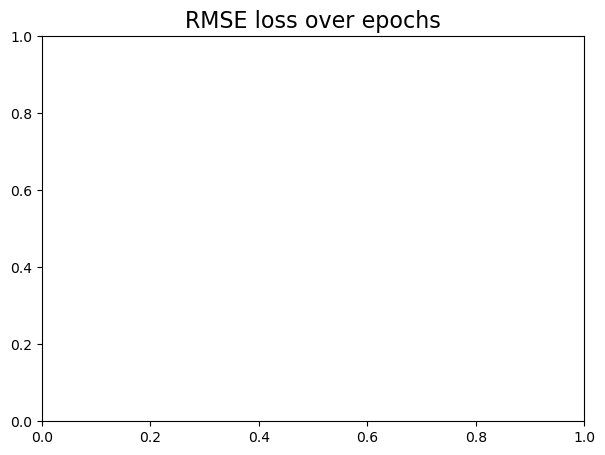

In [32]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model_humidity.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Result and analysis

What did the model see while training?
We are emphasizing and showing again what exactly the model see during training. If you look above, the model fitting code is,

model_humidity.fit(trainX,trainY, 
              epochs=num_epochs, 
              batch_size=batch_size, 
              callbacks=[MyCallback()],verbose=0)

So, the model was fitted with trainX which is plotted below, and trainY which is just the 8 step shifted and shaped vector.

# Now predict the future points
Now, we can generate predictions for the future by passing testX to the trained model.

In [33]:
trainPredict = model_humidity.predict(trainX)
testPredict= model_humidity.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

NameError: name 'model_humidity' is not defined

#See the magic!

When we plot the predicted vector, we see it matches closely the true values and that is amazing given how little training data was used and how far in the future it had to predict. Time-series techniques like ARIMA, Exponential smoothing, cannot predict very far into the future and their confidence interval quickly grows beyond being useful.

Note carefully how the model is able to predict sudden increase in humidity around time-points 12000. There was no indication of such shape or pattern of the data in the training set, yet, it is able to predict the general shape pretty well from the first 7000 data points!

NameError: name 'testPredict' is not defined

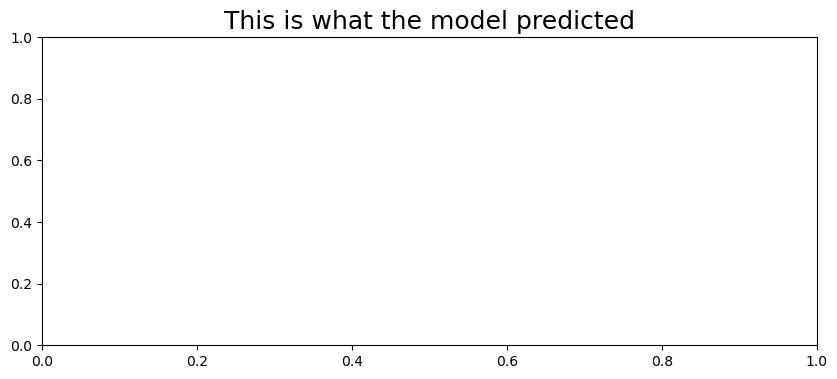

In [34]:
plt.figure(figsize=(10,4))
plt.title("This is what the model predicted",fontsize=18)
plt.plot(testPredict,c='orange')
plt.grid(True)
plt.show()

# Plotting the ground truth and model predictions together
We plot the ground truth and the model predictions together to show that it follows the general trends in the ground truth data pretty well. Considering less than 25% data was used for training, this is sort of amazing. The boundary between train and test splits is denoted by the vertical red line.

There are, of course, some obvious mistakes in the model predictions, such as humidity values going above 100 and some very low values. These can be pruned with post-processing or a better model can be built with propoer hyperparameter tuning.

NameError: name 'predicted' is not defined

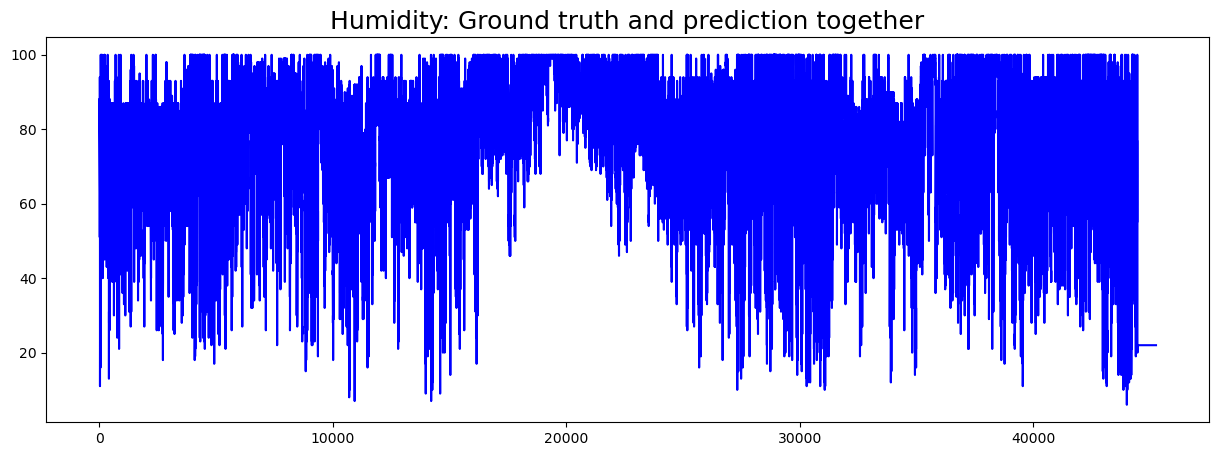

In [35]:
index = humidity_SF.index.values

plt.figure(figsize=(15,5))
plt.title("Humidity: Ground truth and prediction together",fontsize=18)
plt.plot(index,humidity_SF['San Francisco'],c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-20,120)
plt.show()

# Modeling the temperature data
Since we have covered modeling the humidity data step-by-step in detail, we will show the modeling with other two parameters - temperature and pressure - quickly with similar code but not with detailed text.

In [36]:
train = np.array(temp_SF['San Francisco'][:Tp])
test = np.array(temp_SF['San Francisco'][Tp:])

train=train.reshape(-1,1)
test=test.reshape(-1,1)

step = 8

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

/tmp/ipykernel_29739/2685952387.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train = np.array(temp_SF['San Francisco'][:Tp])
/tmp/ipykernel_29739/2685952387.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  test = np.array(temp_SF['San Francisco'][Tp:])


In [37]:
model_temp = build_simple_rnn(num_units=128,num_dense=32,embedding=8,lr=0.0005)

batch_size=8
num_epochs = 2000

model_temp.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

NameError: name 'Sequential' is not defined

NameError: name 'model_temp' is not defined

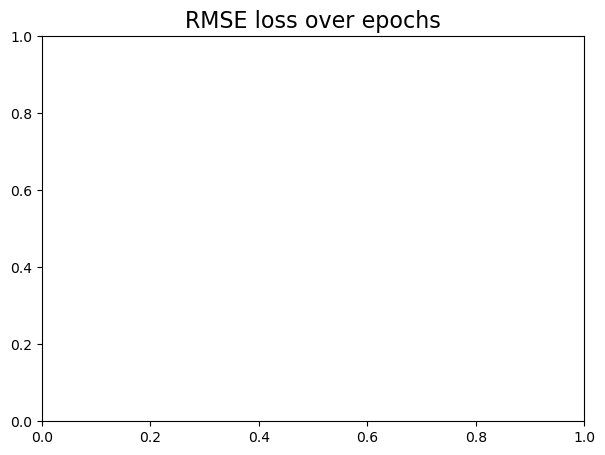

In [38]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model_temp.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [39]:
trainPredict = model_temp.predict(trainX)
testPredict= model_temp.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

NameError: name 'model_temp' is not defined

NameError: name 'predicted' is not defined

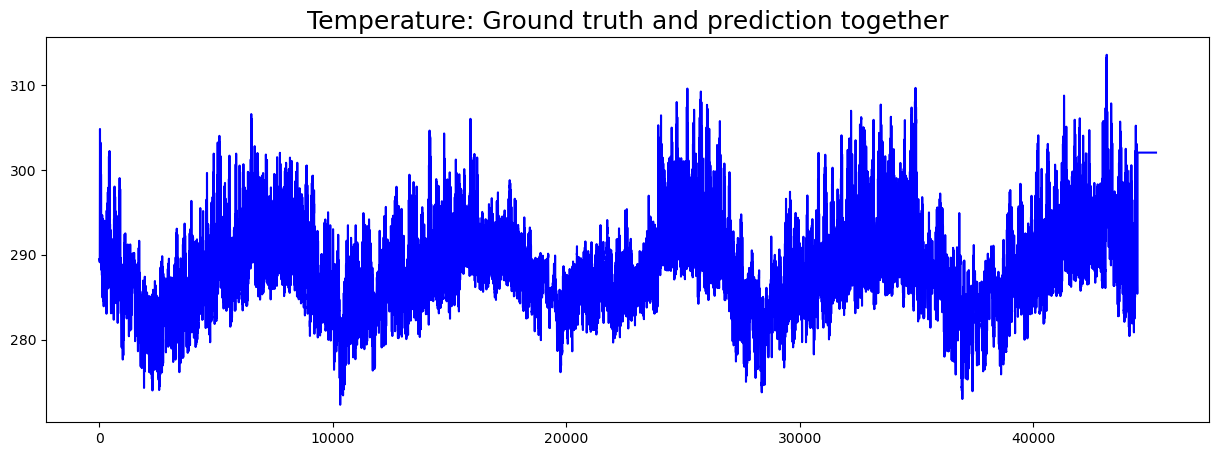

In [40]:
index = temp_SF.index.values

plt.figure(figsize=(15,5))
plt.title("Temperature: Ground truth and prediction together",fontsize=18)
plt.plot(index,temp_SF['San Francisco'],c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Modeling the atmospheric pressure data

In [41]:
train = np.array(pressure_SF['San Francisco'][:Tp])
test = np.array(pressure_SF['San Francisco'][Tp:])

train=train.reshape(-1,1)
test=test.reshape(-1,1)

step = 8

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

/tmp/ipykernel_29739/167665235.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train = np.array(pressure_SF['San Francisco'][:Tp])
/tmp/ipykernel_29739/167665235.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  test = np.array(pressure_SF['San Francisco'][Tp:])


In [42]:
model_pressure = build_simple_rnn(num_units=128,num_dense=32,embedding=8,lr=0.0005)

batch_size=8
num_epochs = 500

model_pressure.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

NameError: name 'Sequential' is not defined

NameError: name 'model_pressure' is not defined

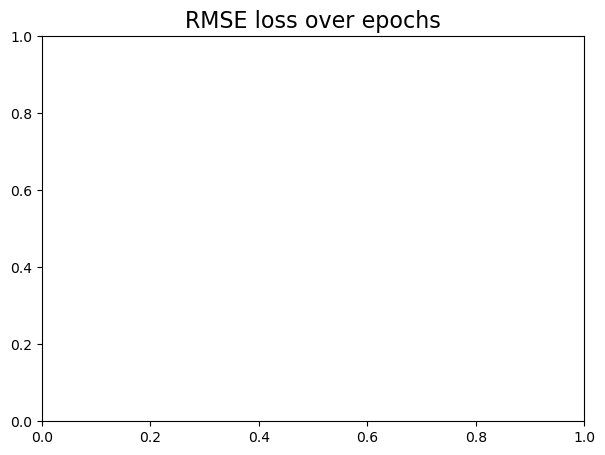

In [43]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model_pressure.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [44]:
trainPredict = model_pressure.predict(trainX)
testPredict= model_pressure.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

NameError: name 'model_pressure' is not defined

NameError: name 'predicted' is not defined

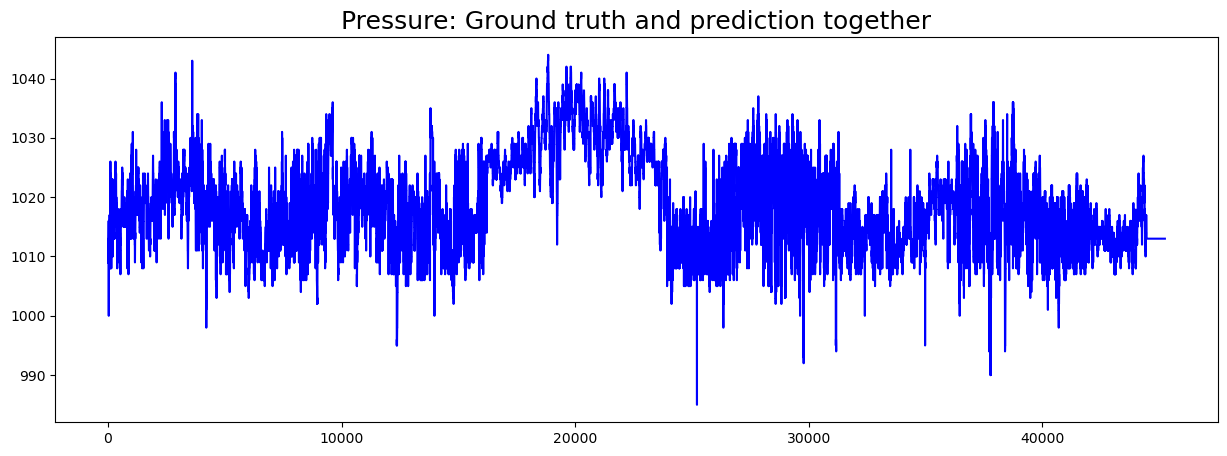

In [45]:
index = pressure_SF.index.values

plt.figure(figsize=(15,5))
plt.title("Pressure: Ground truth and prediction together",fontsize=18)
plt.plot(index,pressure_SF['San Francisco'],c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Again note how the model is able to predict sudden increase in pressure around time-points 18000-22000. There was no indication of such shape or pattern of the data in the training set (the boundary is denoted by the vertical red line), yet, it is able to predict the general shape pretty well from the first 7000 data points!